# UltraPhyx: Physics-Grounded Ultrasound Augmentation  
### Comprehensive Demonstration Notebook

This notebook demonstrates how to use **UltraPhyx**, a physics-informed ultrasound artifact augmentation library.

This notebooks explains:
- How to load ultrasound images  
- How `analyze_ultrasound_scan` works  
- How to create a full `UltraPhyxConfig` with every parameter  
- How to apply individual artifacts  
- How to use the unified `UltraPhyxAugmentor` engine  
- How to view debug information  
- How to integrate UltraPhyx with a PyTorch dataset  


In [1]:
# Basic imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import os

# get the parent directory of Examples/
project_root = os.path.abspath(os.path.join(".."))
# add it to Python path
sys.path.append(project_root)

# Import the UltraPhyx core components
from UltraPhyx.config import UltraPhyxConfig
from UltraPhyx.utils import analyze_ultrasound_scan
from UltraPhyx.UltraPhyxAugmentor import UltraPhyxAugmentor

# Jupyter plotting setup
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.cmap'] = 'gray'

print("UltraPhyx demo environment ready.")

UltraPhyx demo environment ready.


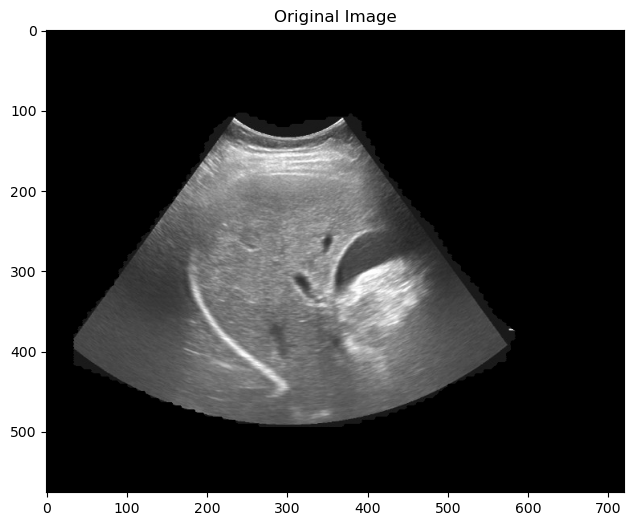

In [2]:
#Example Image
img = cv2.imread("Example_images/example1.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.show()

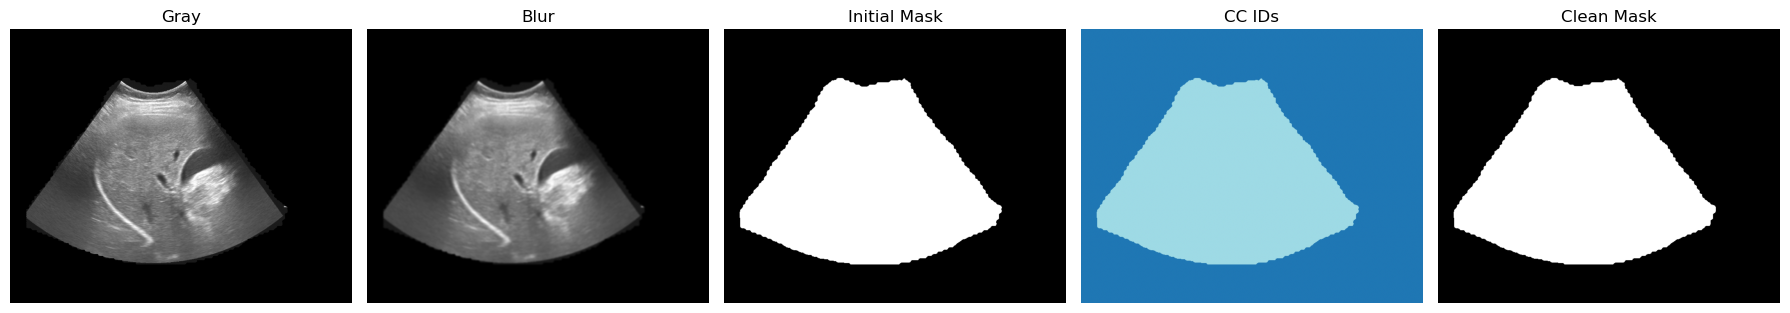

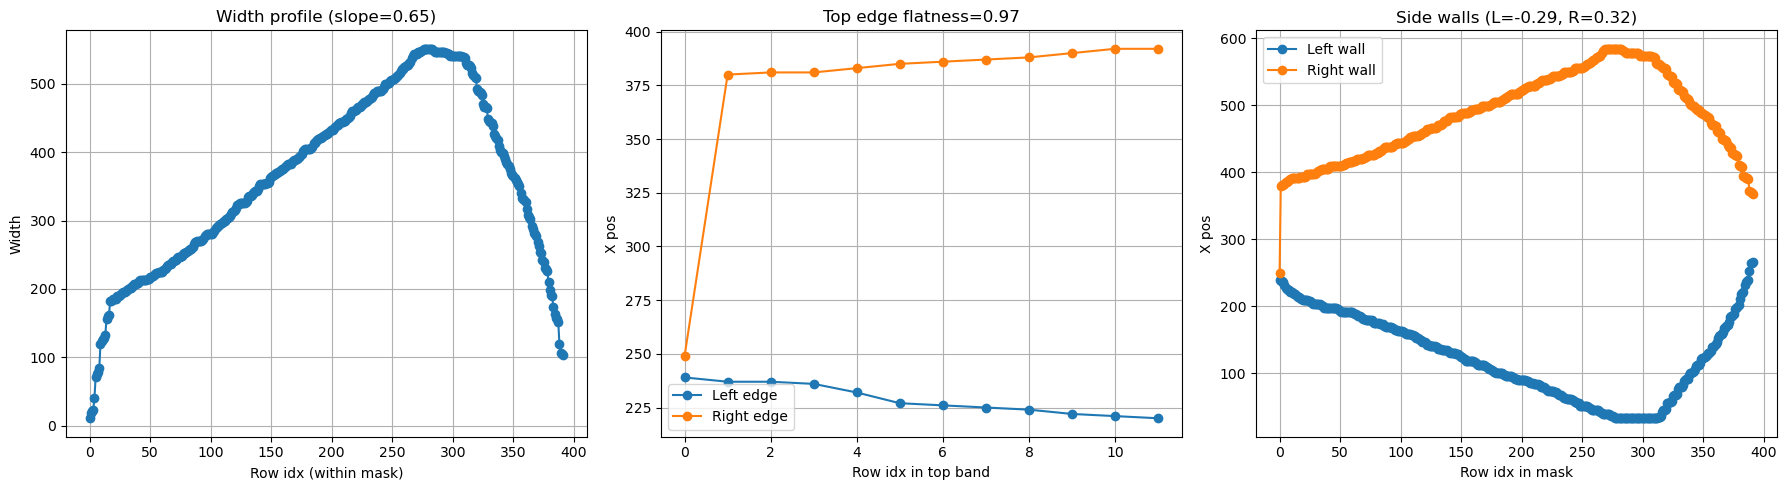


=== LINEAR DETECTOR DECISION ===
Result: NOT linear.
    [LinearCheck] rect_ratio=0.436 < 0.750 → rejects linear.

[Main] Linear check failed → assuming NON-LINEAR and classifying type.


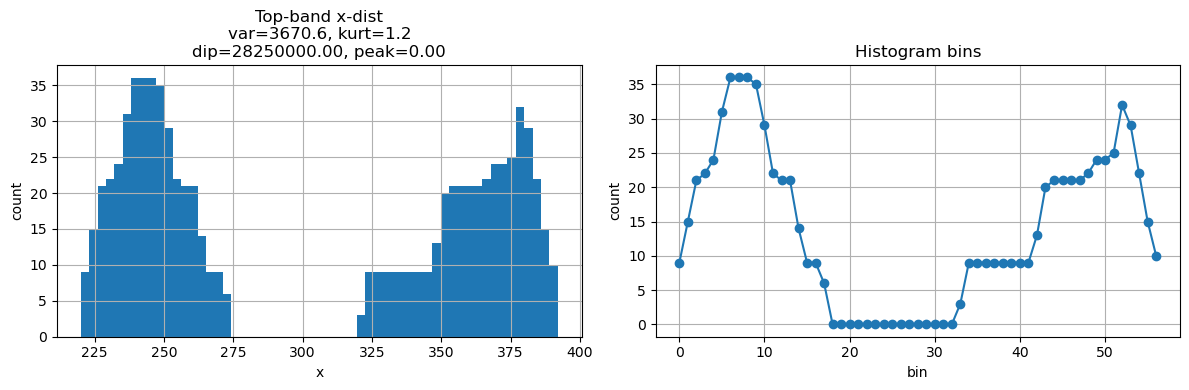


=== NON-LINEAR CLASSIFIER ===
variance=3670.6, dip=28250000.0, peak=0.0
left_slope=-0.29, right_slope=0.32, width_slope=0.65
phased_votes=0, curvi_votes=3
    [Curvilinear] variance=3670.6 ≥ 500.0 → wide footprint.
    [Curvilinear] dip_score=28250000.0 ≥ 5000.0 → stronger two-lobe separation.
    [Curvilinear] outward slopes L=-0.29, R=0.32 (soft vote).


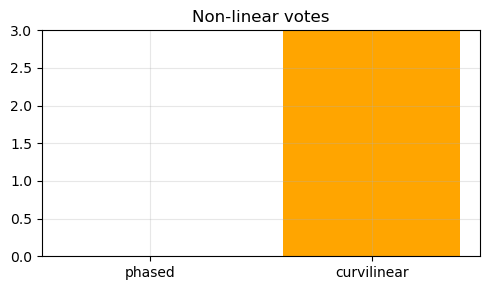

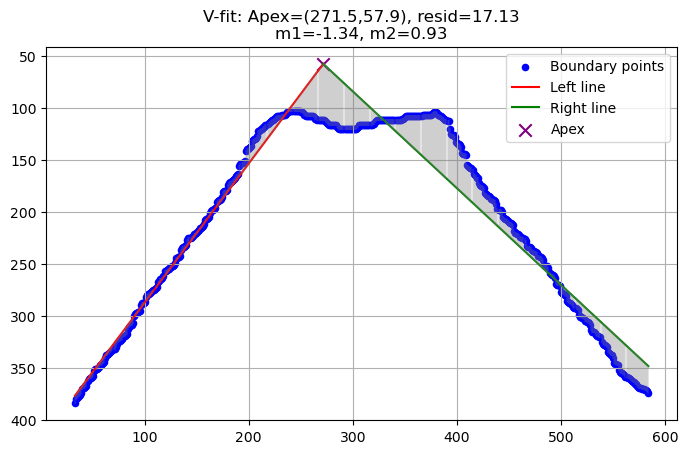

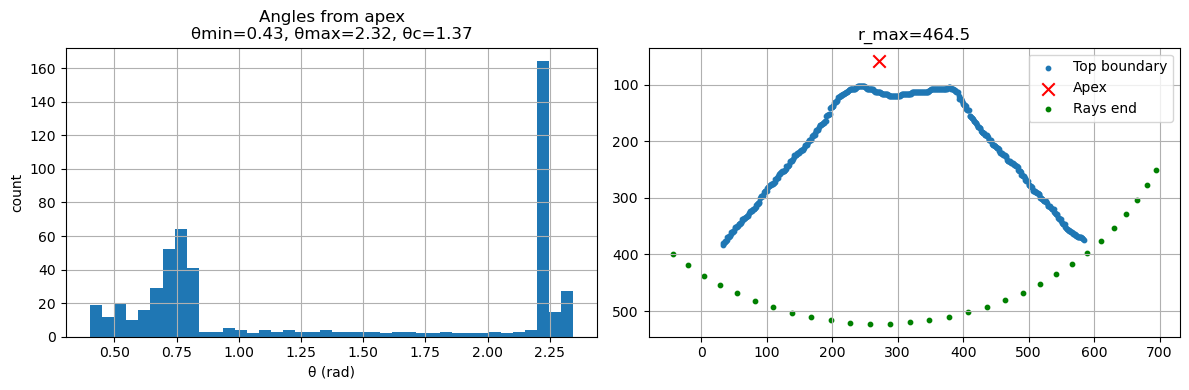

[Main] Final decision: CURVILINEAR (non-linear).

[StructureMask] threshold_percentile: 90.0 → thr: 166.0
[StructureMask] mask_area= 140960 area_thresh= 140 num_components_kept= 3


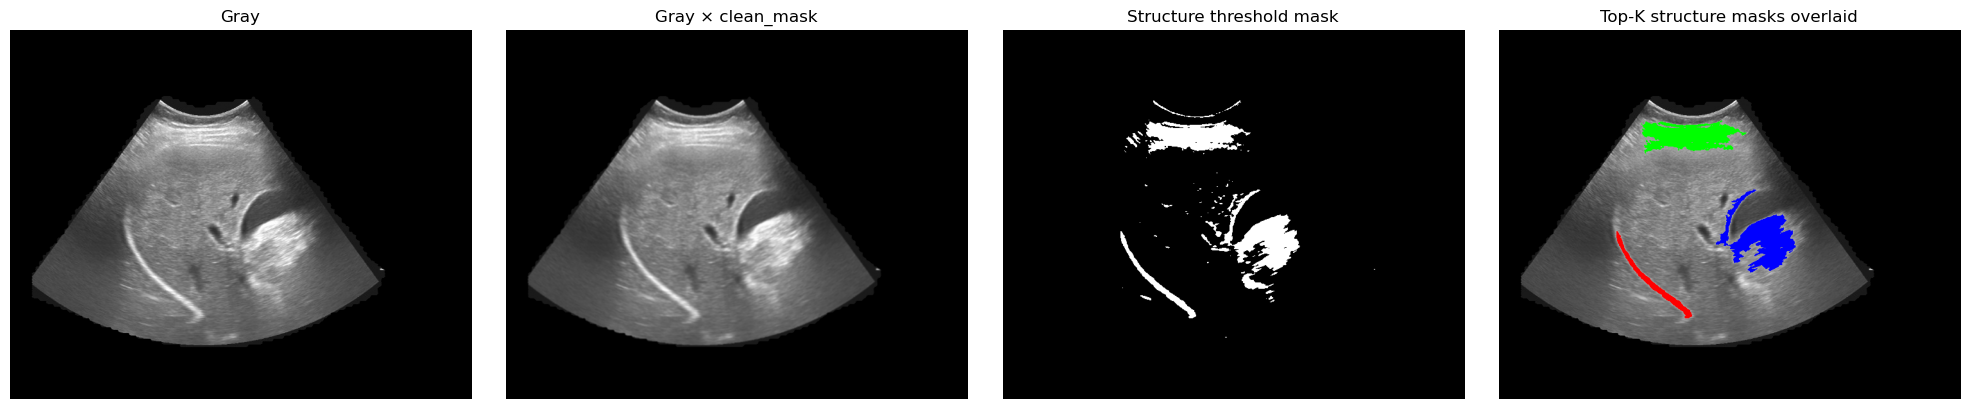

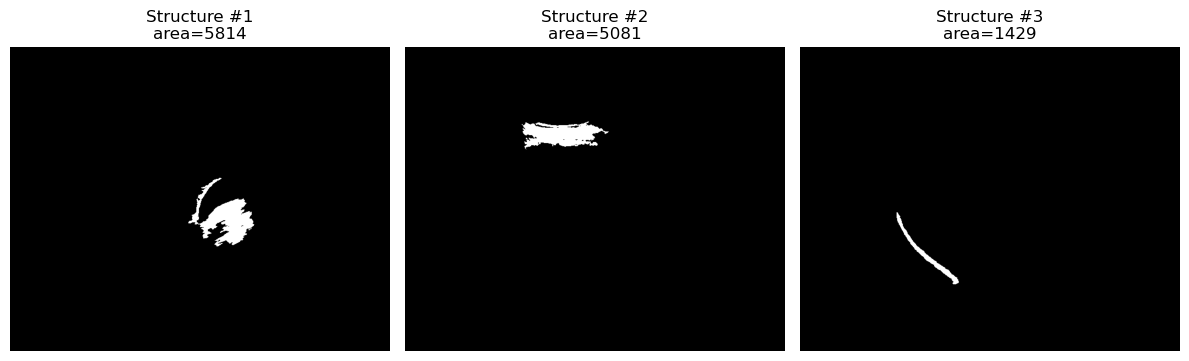

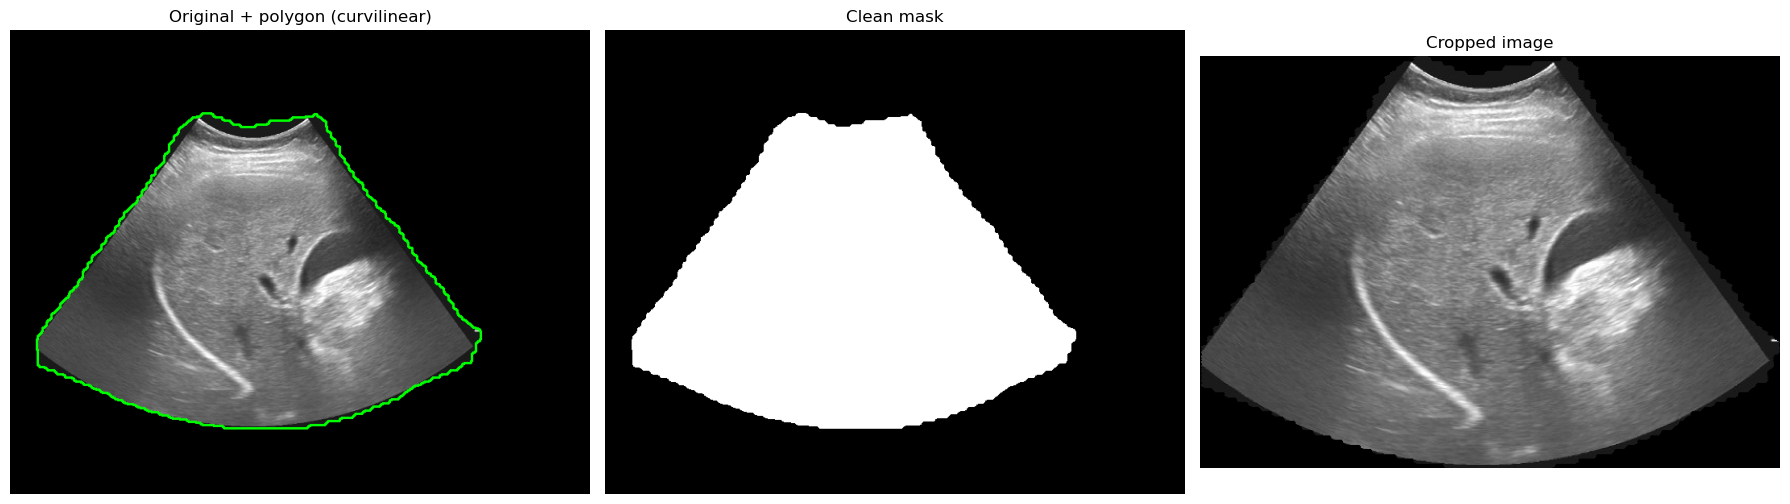

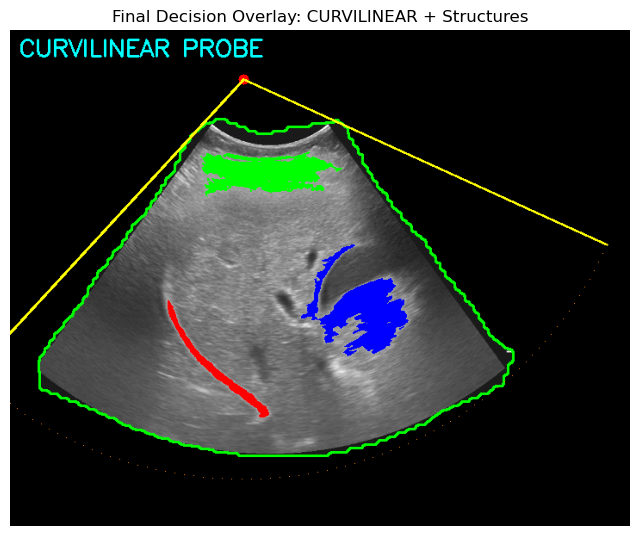


FINAL PROBE CLASSIFICATION
probe_type: curvilinear
geometry keys: ['type', 'apex', 'theta_min', 'theta_max', 'theta_center', 'r_max', 'vfit_residual', 'left_line', 'right_line', 'top_band_variance', 'top_band_kurtosis', 'top_band_dip_score', 'top_band_peak_score']
num_structure_masks: 3
Analysis keys: ['probe_type', 'clean_mask', 'structure_masks', 'structure_info', 'geometry', 'polygon', 'crop_bbox', 'cropped_image', 'original_image']


In [57]:
analysis = analyze_ultrasound_scan(
    img,

    # -------------------------------------------------------------
    # CLEAN MASK PARAMS — defines the ultrasound FAN region
    # -------------------------------------------------------------
    clean_mask_params=dict(
        blur_ksize=7,               # Gaussian blur size (odd). Smooths before thresholding.
                                    # Larger = more stable mask, but loses thin structures.

        brightness_factor=0.35,     # Percent of max brightness used for initial threshold.
                                    # Lower = larger mask; higher = smaller “clean” fan area.

        morph_ksize=15,             # Morphological closing kernel size.
                                    # Fills holes & creates continuous ultrasound fan region.

        disconnect_threshold=0.05   # Removes tiny isolated mask fragments <5% of full area.
                                    # Used to prevent speckle blobs from being misidentified.
    ),


    # -------------------------------------------------------------
    # STRUCTURE DETECTION PARAMS — find bright structural blobs
    # -------------------------------------------------------------
    structure_params=dict(
        threshold_percentile=90.0,  # Select top 10% brightest pixels for structure seeds.
                                    # Higher = only extremely bright structures kept.

        max_components=3,           # Keep up to 3 of the largest connected components.
                                    # Avoids noise + minor blobs.

        min_rel_area=0.001          # Minimum area (relative to image) required to keep
                                    # structure. Filters tiny speckle-like regions.
    ),


    # -------------------------------------------------------------
    # LINEAR SHAPE ANALYSIS — parameters for _analyze_linear_shape
    # Used to detect long, bright linear structures:
    #   ribs, bright fascia, diaphragm, catheters, needles, bone
    # -------------------------------------------------------------
    linear_params=dict(
        band_height=12,             # Height (in pixels) of top & bottom bands used to
                                    # compare width & flatness of linear structures.

        rect_ratio_threshold=0.75,  # Ratio: width_top / width_bottom.
                                    # Values close to 1 indicate rectangular, uniform width.
                                    # Lower values indicate tapered V-shapes.

        slope_threshold=2.0,        # Linear slope of width profile from top→bottom.
                                    # Higher slope = widening or narrowing shape.

        top_edge_flatness_threshold=0.70,
                                    # Flatness measure for the top edge of structure.
                                    # 0.70 = requires reasonably flat top boundary.

        side_walls_slope_threshold=1.0
                                    # Sidewall angle thresholds for verticality.
                                    # Lower = straighter sidewalls → more “linear”.
    ),


    # -------------------------------------------------------------
    # NONLINEAR SHAPE CLASSIFICATION — parameters for _classify_non_linear
    # Used to detect curvilinear, blob-like, or V-shaped structures.
    # -------------------------------------------------------------
    nonlinear_params=dict(
        var_threshold=500.0,         # Variance of boundary curvature.
                                    # Higher variance = more irregular or curving structure.

        dip_threshold=5000.0          # Detect dips in vertical width profile.
                                    # Useful to distinguish V-shapes, U-shapes, or convex shapes.
    ),


    # -------------------------------------------------------------
    # DEBUG MODE
    # -------------------------------------------------------------
    show_debug=True                # True = visualize intermediate masks, structures,
                                    # bright thresholding, connected components, and shape
                                    # analysis tools. Very useful for parameter tuning.
)

print("Analysis keys:", list(analysis.keys()))

#### Explanation:

clean_mask → mask of valid ultrasound region

structure_masks → segmented key bright structures

probe_type → "linear", "curvilinear", "phased"

apex_point → geometric apex

fan_angle_deg → if probe is fan geometry

bounds → region cropping

## This configuration enables every artifact with fully detailed parameters:
### Notice that when specifying parameters, we can specify one value or a range of values to be uniformly sampled from using a tuple like (min_value, max_value)

In [56]:
cfg = UltraPhyxConfig(
    mode="any",                 # "any" = each artifact may apply based on its probability;
                                # "single" = exactly one artifact chosen per image;
                                # "random_k" = choose k artifacts without replacement.

    p_global=0.85,              # 85% chance to apply ANY augmentation at all.
                                # 15% of images pass through clean.

    k=2,                 # Used only if mode == "random_k".
                                # Means apply exactly 2 randomly chosen artifacts.

    # ---------------------------------------------------------------
    # ARTIFACT PROBABILITIES — per-artifact probabilities
    # Used when mode = "any" or "single".
    # ---------------------------------------------------------------
    artifact_probs={
        "mirror": 0.6,          # 60% chance to apply mirror artifact.
        "shadow": 0.7,          # 70% chance to add acoustic shadow.
        "reverb": 0.9,          # 90% chance to include reverberations.
        "gain": 0.5,            # 50% chance to modify gain.
        "speckle": 0.8,         # 80% chance to adjust speckle.
        "depth_atten": 1.0,     # Always apply depth attenuation (if global p_global allows).
    },

    # ---------------------------------------------------------------
    # PER-ARTIFACT PARAMETER DICTIONARIES
    # Each artifact receives a dict of custom simulation settings.
    # If set to None, defaults are used.
    # ---------------------------------------------------------------
    artifact_configs={

        # ----------------------
        # MIRROR ARTIFACT
        # ----------------------
        "mirror": {
            "max_depth_fraction": (0.30,0.35),                # Only generate mirror reflections up to this fraction
                                                       # of the image depth beneath the structure. 
                                                       # Lower values = shallower reflections. Max value is 35%.
        
            "max_tilt_deg": 45.0,                      # Maximum allowed tilt of the mirror axis relative
                                                       # to vertical. Controls how slanted reflections 
                                                       # are allowed to be.
        
            "mirror_strength": (0.65,0.95),                    # Strength of mirrored intensity (contrast).
                                                       # 1.0 = fully reflected, 0.0 = no effect.
        
            "decay_rate": (0.1,1.0),                         # Exponential decay of intensity with depth.
                                                       # Higher value = reflection fades faster.
        
            "lateral_blur_px": 18,                     # Horizontal Gaussian blur applied to the reflection
                                                       # to blend smoothly into surrounding tissue.
                                                       # Controls edge softness horizontally.
        
            "original_remaining_threshold_percentage": (0.01,0.05),
                                                       # Determines how much of the *original* pixel intensity
                                                       # remains when mixing the reflection.
                                                       # If original > threshold, reflection is not applied.
                                                       # Helps avoid overpainting real structures.
        
            "opp_angle_thresh_deg": 45,                # Opposite-angle threshold for validating whether
                                                       # the mirrored structure is allowed to appear
                                                       # (prevents impossible geometry reflections).
        
            "seed": None,                              # Optional seed for deterministic randomness.
        
            "show_debug": False,                        # If True, returns masks, axes, reflection line,
                                                       # and intermediate maps for visualization.
        },


        # ----------------------
        # SHADOW ARTIFACT
        # ----------------------
        "shadow": {
            "max_depth_fraction": 0.33,          # Shadow extends downwards only this fraction
                                                 # of the image height. Controls vertical reach.
                                                 # 0.33 ≈ upper 1/3 of the image.
        
            "structure_dilate_iters": (1,2),         # Number of morphological dilation iterations
                                                 # applied to the bright structure mask before
                                                 # computing the shadow below it.
                                                 # Thicker structure mask → broader shadow base.
        
            "fan_spread_factor": (0.6,20.0),     # How much the shadow widens with depth.
                                                 # For linear probes = minimal effect.
                                                 # For curvilinear/phased probes:
                                                 #    0.5 = moderate widening
                                                 #    higher values = dramatic cone-shaped shadow.
        
            "shadow_strength": 0.65,              # Maximum darkening intensity applied in shadow.
                                                 # 0 = no shadow, 1 = fully dark “black hole”.
        
            "decay_rate": 2.0,                   # Controls how quickly shadow intensity fades
                                                 # with depth. Higher → fades faster.
        
            "edge_blur_ksize": 9,                # Gaussian blur kernel size for softening edge
                                                 # transitions. Must be odd. Larger → softer edges.
        
            "m": None,                           # Nakagami m-shape parameter.
                                                 # If None → estimate automatically from pixels
                                                 # under clean_mask.
                                                 # Controls speckle cluster tightness inside shadow.
        
            "Omega": None,                       # Nakagami scale parameter (overall speckle energy).
                                                 # If None → auto-estimate from clean tissue.
        
            "seed": None,                        # Optional seed for reproducible shadow randomness.
        
            "show_debug": False,                 # Output debug maps (shadow mask, feather, etc.).
        },


        # ----------------------
        # REVERBERATION ARTIFACT
        # ----------------------
        "reverb": {
            "max_depth_fraction": 0.30,         # Reverberations extend downward only through
                                                # the top 35% of the image depth.
        
            "prefer_thin_prob": 0.8,            # 50% chance to pick the thinnest bright structure
                                                # (thin structures such as needles, ribs, calcifications
                                                # produce the strongest reverbs).
        
            "max_reverbs": 15,                   # Maximum number of reverberation copies (orders).
                                                # Real scans often show 2–4; 5 is an upper realistic limit.
        
            "decay_rate": (0.1,0.9),                  # Exponential intensity decay per reverb order.
                                                # Higher = echoes fade more quickly with depth.
        
            "spacing_jitter": 0.20,             # Adds randomness to vertical spacing between echoes.
                                                # 0 = perfect periodic lines; >0 → more natural variation.
        
            "base_spacing_px": 15.0,            # Typical pixel spacing between reverberation lines
                                                # before jitter. Depends on probe pulse length + geometry.
        
            "lateral_feather_px": 5,           # Lateral blur radius applied to each reverb replica.
                                                # Real reverbs do not have perfectly sharp boundaries.
        
            "strength": (0.8,1.0),                    # Global scaling factor for reverb intensity.
                                                # 1.0 = full strength; <1.0 = subtle reverbs.

            "intensity_base": (0.5,0.8),              # Baseline multiplicative scaling for all reverb copies.
                                                # Slightly <1.0 makes reverbs dimmer than original structure.
        
            "intensity_noise_amp": 0.8,         # Amount of Nakagami-like random modulation applied
                                                # to each echo. Adds realistic granular variation.
        
            "seed": None,                       # Optional random seed for reproducible reverberation patterns.
        
            "show_debug": False,                # Output debug visualizations (masks, spacing, echoes).
        },

        # ----------------------
        # GAIN ARTIFACT
        # ----------------------
        "gain": {
            "gain": (0.6,1.3),                     # Global multiplicative gain applied to the entire image.
                                             # 1.0 = no change.
                                             # >1.0 = brightens image overall.
        
            "depth_gain": (0.1,0.6),              # Optional depth-dependent exponential gain.
                                             # None = disabled.
                                             # If set to something like 0.002 → boosts deeper pixels
                                             # more than shallow ones (simulates deep TGC adjustments).
        
            "feather_px": 14,                # Feathers the clean_mask boundaries, so gain is applied
                                             # smoothly without harsh edges or abrupt transitions.
                                             # Larger values = softer blending.
        
            "seed": None,                    # Optional random seed for reproducible gain jitter
                                             # (used if you later add random per-row gain modulation).
        
            "show_debug": False,             # When True, returns intermediate maps:
                                             # gain map, feather mask, clean mask overlay, etc.
        },


        # ----------------------
        # SPECKLE ARTIFACT
        # ----------------------
        "speckle": {
            "target_m": (0.5,1.6),         # Override for Nakagami m-shape parameter.
                                           # None = auto-estimate from clean_mask region.
                                           # Lower m (0.5–1.0) = stronger speckle fluctuations.
                                           # Higher m (1.2+) = smoother, less grainy speckle.
        
            "target_Omega": None,          # Override for Nakagami scale parameter (speckle energy).
                                           # None = auto-estimated.
                                           # Larger Omega = brighter speckle envelope.
        
            "strength": (0.3,0.8),         # How strongly the new speckle replaces the old one.
                                           # 0.0 = keep original image entirely.
                                           # 1.0 = fully replace original speckle with simulated one.
                                           # Typical realistic range: 0.3–0.7.
        
            "feather_px": 12,              # Smooth blending around clean_mask boundaries to avoid
                                           # sudden speckle transitions. Controls blur radius.
        
            "seed": None,                  # Optional RNG seed for deterministic speckle generation.
        
        },


        # ----------------------
        # DEPTH ATTENUATION (TGC / body habitus simulation)
        # ----------------------
        "depth_atten": {
            "strength": (0.75,2.5),               # 0 = no attenuation
                                           # 1 = full physical attenuation curve applied.
                                           # Controls how strongly intensity fades with depth.
        
            "curve_shape": (1.5,4.5),            # Exponent shaping depth normalization:
                                           # depth_norm ** curve_shape.
                                           # >1 makes attenuation MUCH steeper (more realistic).
        
            "habitus_alpha": (0.1,3.0),          # Exponential decay coefficient (physical attenuation).
                                           # Higher = deeper regions get much darker.
                                           # Models overweight/obese patients or high attenuation tissue.
        
            "enable_tgc": True,            # If True, simulate TGC sliders correcting for depth loss.
        
            "tgc_strength": (0.3,0.8),           # Amplitude of TGC randomness.
                                           # Higher = more aggressive slider variation.
        
            "tgc_rescue": (0.1,0.8),       # Upward bias in deep gain.
                                           # Models user pulling bottom TGC sliders UP to brighten deep field.
        
            "tgc_num_knots": (3,10),       # Number of depth “sliders”.
                                           # More knots = more wiggly curve (fine control).
                                           # Fewer knots = smoother TGC profile.
        
            "noise_amplitude": (0.1,1.0),  # Strength of Nakagami-based noise modulation.
                                           # Models loss of SNR with depth + electronic noise.
        
            "seed": None,                  # RNG seed for deterministic attenuation/TGC/noise.
            "show_debug": False,           # Show all curves + maps (habitus, TGC, combined gain).
        },
    },

    # ---------------------------------------------------------------
    # DEBUGGING FLAGS
    # ---------------------------------------------------------------
    seed=42,                  # Forces a determinstic algorithm
)

cfg


UltraPhyxConfig(mode='any', k=2, p_global=0.85, artifact_probs={'mirror': 0.6, 'shadow': 0.7, 'reverb': 0.9, 'gain': 0.5, 'speckle': 0.8, 'depth_atten': 1.0}, artifact_configs={'mirror': {'max_depth_fraction': (0.3, 0.35), 'max_tilt_deg': 45.0, 'mirror_strength': (0.65, 0.95), 'decay_rate': (0.1, 1.0), 'lateral_blur_px': 18, 'original_remaining_threshold_percentage': (0.01, 0.05), 'opp_angle_thresh_deg': 45, 'seed': None, 'show_debug': False}, 'shadow': {'max_depth_fraction': 0.33, 'structure_dilate_iters': (1, 2), 'fan_spread_factor': (0.6, 20.0), 'shadow_strength': 0.65, 'decay_rate': 2.0, 'edge_blur_ksize': 9, 'm': None, 'Omega': None, 'seed': None, 'show_debug': False}, 'reverb': {'max_depth_fraction': 0.3, 'prefer_thin_prob': 0.8, 'max_reverbs': 15, 'decay_rate': (0.1, 0.9), 'spacing_jitter': 0.2, 'base_spacing_px': 15.0, 'lateral_feather_px': 5, 'strength': (0.8, 1.0), 'intensity_base': (0.5, 0.8), 'intensity_noise_amp': 0.8, 'seed': None, 'show_debug': False}, 'gain': {'gain': (

In [36]:
augmentor = UltraPhyxAugmentor(cfg)
print("Augmentor created.")

Augmentor created.


Applying artifacts: mirror


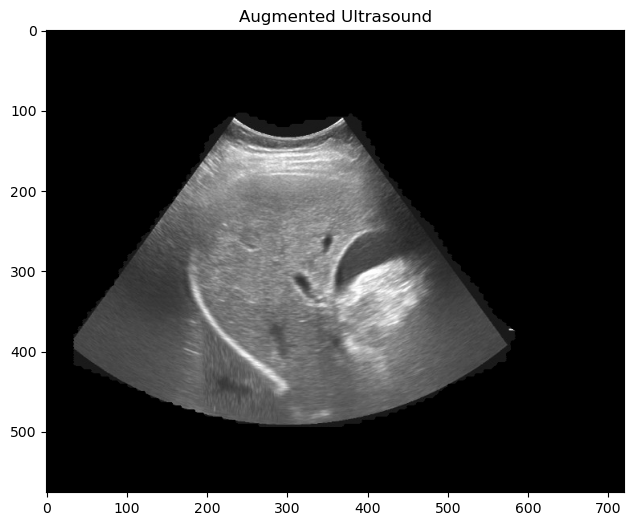

In [55]:
aug_img = augmentor(img, analysis, show_choices=True)

plt.imshow(aug_img, cmap='gray')

plt.title("Augmented Ultrasound")
plt.show()
